In [1]:
import sys
sys.path.append("../data/saved_models/")
sys.path.append("../model_scripts/")
sys.path.append("../utils/")
import os
import json

import numpy as np
import torch
from scipy import stats

import matplotlib.pyplot as plt
import fig2_align_plots

import fig2_align_analysis as rnn
import basic_analysis as basic
import model_utils
import dim_alignment as dim
from task import generate_batch

In [2]:
# file paths
data_folder = f"../data/saved_models/1d_2map/"
save_folder = f"../figures/fig2_align_plots/"

if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)

save folder exists


In [3]:
# get the model IDs for all saved models
model_IDs = os.listdir(data_folder)

# select example model
ex_id = 0
model_ID = model_IDs[ex_id]

In [4]:
# get sample rnn data
inputs, outputs, targets = model_utils.sample_rnn_data(data_folder, model_ID)
X, map_targ, pos_targ = model_utils.format_rnn_data(outputs["hidden_states"],\
                                                    targets["map_targets"],\
                                                    targets["pos_targets"])

In [5]:
''' are the position outputs orthogonal? '''
n_models = len(model_IDs)

pos_out_angle = np.zeros(n_models)
for i, m_id in enumerate(model_IDs):
    # get the model weights
    model, _, _ = model_utils.load_model_params(data_folder, model_ID)
    pos_out_w = model.readout_layer_pos.weight
    pos_out_w = pos_out_w.detach().numpy().T
    
    # angle between output weights
    pos_out_angle[i] = dim.cosine_sim(pos_out_w[:, 0], pos_out_w[:, 1])
    
avg_angle = np.rad2deg(np.arccos(np.abs(np.mean(pos_out_angle))))
print(f'the avg angle between position outputs is {int(avg_angle)} deg.')

the avg angle between position outputs is 88 deg.


model 1 of 15
model 2 of 15
model 3 of 15
model 4 of 15
model 5 of 15
model 6 of 15
model 7 of 15
model 8 of 15
model 9 of 15
model 10 of 15
model 11 of 15
model 12 of 15
model 13 of 15
model 14 of 15
model 15 of 15
mean W * xi = 9.23e-06
s.e.m. W * xi = 1.63e-05


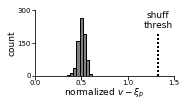

In [6]:
''' Figure 2C: comparison of the true and ideal remap vectors '''
f, ax = fig2_align_plots.plot_c(data_folder, model_IDs)
f.savefig(f'{save_folder}remap_vectors.png', dpi=600, bbox_inches='tight')
plt.show()

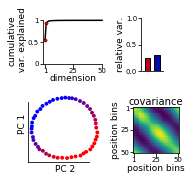

In [5]:
''' Figure 2D, E: example showing the geometry of the remap vectors '''
f = fig2_align_plots.plot_d_e(data_folder, model_ID)
f.savefig(f'{save_folder}remap_dims.png', dpi=600, bbox_inches='tight')
plt.show()

In [5]:
from sklearn.decomposition import PCA

# get the remap vectors
xi_p, _, _ = rnn.compute_remap_vectors(data_folder, model_ID)

# data params
n_dims = np.min(xi_p.shape)
spacer = n_dims / 50
pos_bins = np.linspace(0, 2*np.pi, n_dims)

# PCA on remap vectors
xi_bar = xi_p - np.mean(xi_p, axis=0)
pca = PCA().fit(xi_bar)
var = pca.explained_variance_
total_var_remap = np.sum(var)
pct_var = (var / total_var_remap)
cum_var = np.cumsum(pct_var)
x_, y_ = PCA(n_components=2).fit_transform(xi_bar).T

In [12]:
# get the variance of the full network
X_bar = X - np.mean(X, axis=0)
pca = PCA().fit(X_bar)
var = pca.explained_variance_
total_var_full = np.sum(var)

In [13]:
# get the variance of the position subspaces
pos_ring = rnn.compute_pos_ring(data_folder, model_ID)
pos_bar = pos_ring - np.mean(pos_ring, axis=0)
pca = PCA().fit(pos_bar)
var = pca.explained_variance_
total_var_pos = np.sum(var)

In [50]:
# get the relative variance
rel_var = np.asarray([
    total_var_remap / total_var_full,
    total_var_pos / total_var_full
])

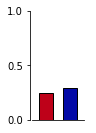

In [60]:
# colors
map_col = 'xkcd:scarlet'
pos_col = 'xkcd:cobalt blue'

# fig params
f, ax = plt.subplots(1, 1, figsize=(1, 2))
bar_colors = [map_col, pos_col]
xcoords = [1, 2]

# plot relative variance
ylims = ax.get_ylim()
ax.bar(xcoords, rel_var,
       width=0.6, bottom=ylims[0],
       color=bar_colors, alpha=1, edgecolor='k')

# ticks and lims
ax.set_xticks([])
ax.set_yticks(np.arange(0, 1.2, 0.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_bounds(0, 1)
ax.spines['bottom'].set_bounds(xcoords[0] - 0.6,
                                  xcoords[-1] + 0.6)
ax.set_xlim([xcoords[0] - 0.7,
                xcoords[-1] + 0.7])
ax.set_ylim([0, 1])

plt.show()

In [38]:
print(np.trace(pos_bar.T @ pos_bar) / 49)
print(PCA().fit(pos_bar).explained_variance_.sum())

2.0181507531677574
2.0181507531677565


(-1, 7)

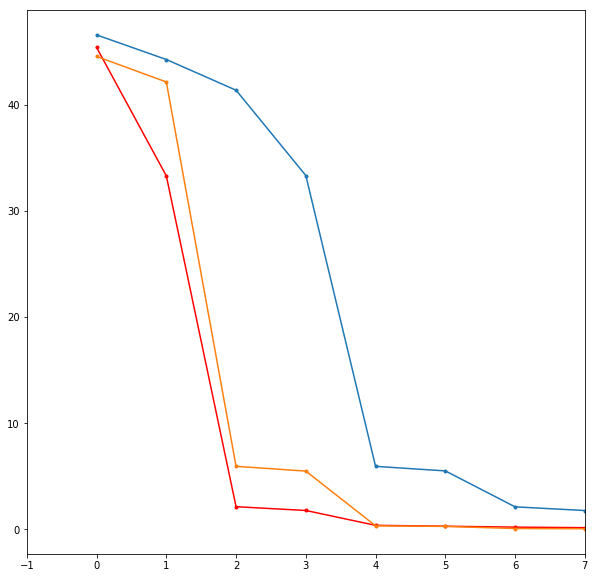

In [49]:
plt.figure(figsize=(10, 10))
plt.plot(PCA().fit(np.row_stack([xi_bar, pos_bar])).explained_variance_ * 99, '.-')
plt.plot(PCA().fit(xi_bar).explained_variance_ * 49, '.-r')
plt.plot(PCA().fit(pos_bar).explained_variance_ * 49, '.-')
plt.xlim([-1, 7])

In [26]:
np.trace(xi_bar.T @ xi_bar)

84.04059216607038

In [27]:
total_var_remap

1.7151141258381728

In [28]:
total_var_pos

2.0181507531677565